<a href="https://colab.research.google.com/github/jjrodcast/MaskDectector/blob/master/MaskDetector.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Face Mask Detector



#### 1. Cargamos librerías

In [1]:
from google.colab import files
uploaded = files.upload()

Saving Maskdectector.zip to Maskdectector.zip


In [2]:
import zipfile
import io
import os
data = zipfile.ZipFile(io.BytesIO(uploaded['Maskdectector.zip']), 'r')
data.extractall()

In [5]:
!pip install mtcnn
from mtcnn import MTCNN
import numpy as np
import tensorflow as tf
import tensorflow.keras
import torch
from PIL import Image
import cv2
import timeit
import matplotlib.pyplot as plt
from utils.bounding_box import resizeBoundingBox
from utils.predictor_keras import predict
from utils.detect_faces import detect_faces, detect_faces_with_mask

#### 2. Variables de configuración

In [6]:
IMG_WIDTH = 160 # Ancho de la imagen
IMG_HEIGHT = 160 # Alto de la imagen
BBOX_PERCENTAGE = 0.05 # Porcentage de ampliación del bounding box
CONFIDENCE = 0.80 # Porcentage de confidencia del detector de rostros
classes = ['no_mask', 'mask'] # Clases de la capa final

#### 3. Carga de imagen original

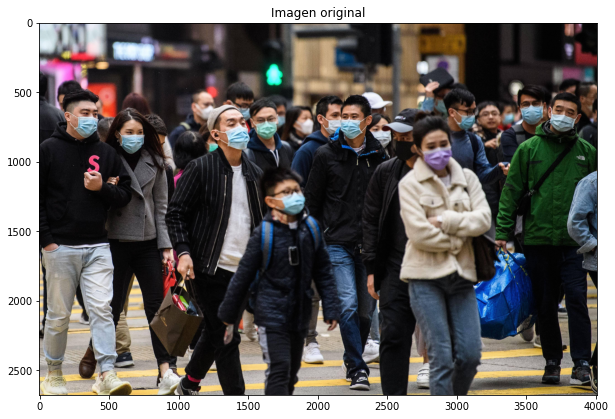

In [19]:
img = cv2.imread('multimedia/test_102.jpg')
img_color = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(10, 10))
plt.title("Imagen original")
plt.imshow(img_color)
plt.show()

#### 4. Cargamos modelo detector de rostros

In [20]:
# Detector de rostros (Multi-Task Cascaded Convolutional Neural Network)
face_detector = MTCNN()

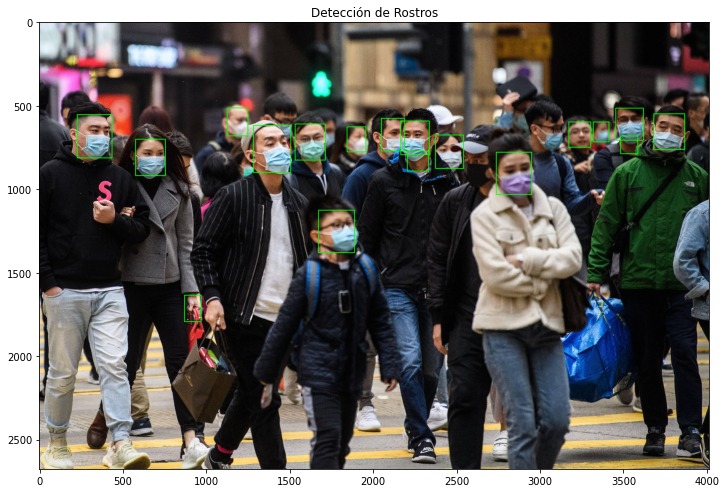

In [21]:
# Verificamos la detección de rostros
image_detected = detect_faces(img_color, face_detector, confidence=CONFIDENCE, target_size=(IMG_WIDTH, IMG_HEIGHT))
plt.figure(figsize=(12, 12))
plt.title('Detección de Rostros')
plt.imshow(image_detected)
plt.show()

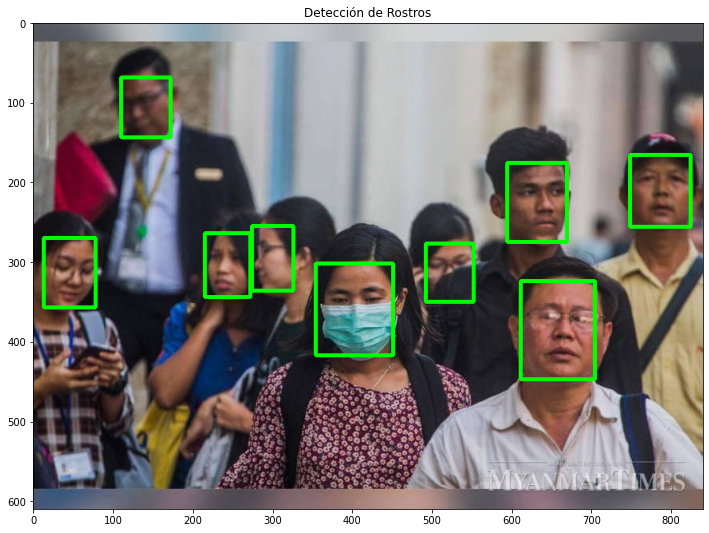

In [22]:
# Probamos sobre otra imagen
img_test = cv2.imread('multimedia/test_134.jpg')  # 163  134
img_color_test = cv2.cvtColor(img_test, cv2.COLOR_BGR2RGB)
image_detected2 = detect_faces(img_color_test, face_detector, confidence=CONFIDENCE, target_size=(IMG_WIDTH, IMG_HEIGHT))
plt.figure(figsize=(12, 12))
plt.title('Detección de Rostros')
plt.imshow(image_detected2)
plt.show()

####5. Cargando el mejor modelo con Pytorch

En el modelo de PyTorch se usó Transfer Learning Freeze usando ResNet50

In [23]:
if torch.cuda.is_available():
    map_location=lambda storage, loc: storage.cuda()
else:
    map_location='cpu'

# model_torch = torch.load('models/model_9.model')  
model_torch = torch.load('models/model_9.model', map_location=map_location)


### 6. Detectamos si la persona tiene mascarillas en imágenes

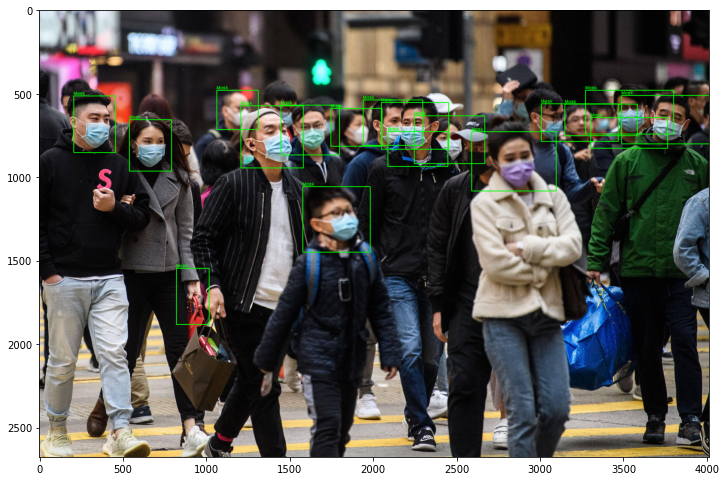

In [24]:
image_mask_detection = detect_faces_with_mask(img_color, face_detector, model_torch, ['mask', 'no_mask'], 
                                              CONFIDENCE, bbox_percentage=BBOX_PERCENTAGE, predictor='torch', 
                                              target_size=(IMG_WIDTH, IMG_HEIGHT))

plt.figure(figsize=(12, 12))
plt.imshow(image_mask_detection)
plt.show()

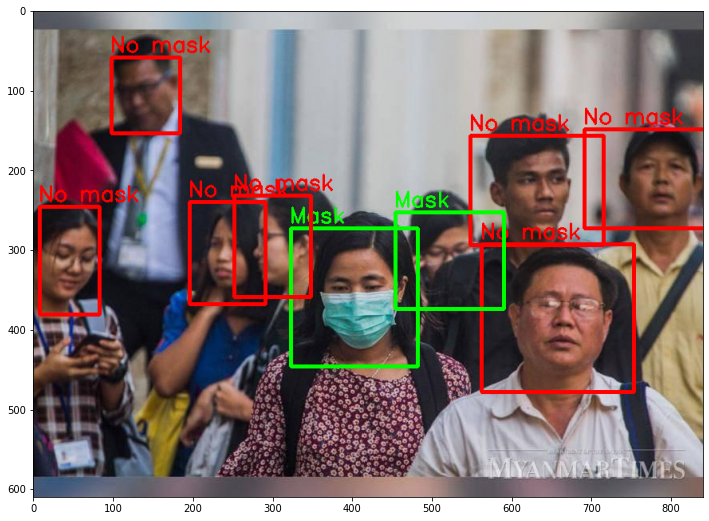

In [27]:
# Probamos sobre otra imagen
img_test = cv2.imread('multimedia/test_134.jpg') #134  128
img_color = cv2.cvtColor(img_test, cv2.COLOR_BGR2RGB)
image_mask_detection = detect_faces_with_mask(img_color, face_detector, model_torch, ['mask', 'no_mask'], 
                                              CONFIDENCE, bbox_percentage=0.07, predictor='torch', 
                                              target_size=(IMG_WIDTH, IMG_HEIGHT))

plt.figure(figsize=(12, 12))
plt.imshow(image_mask_detection)
plt.show()

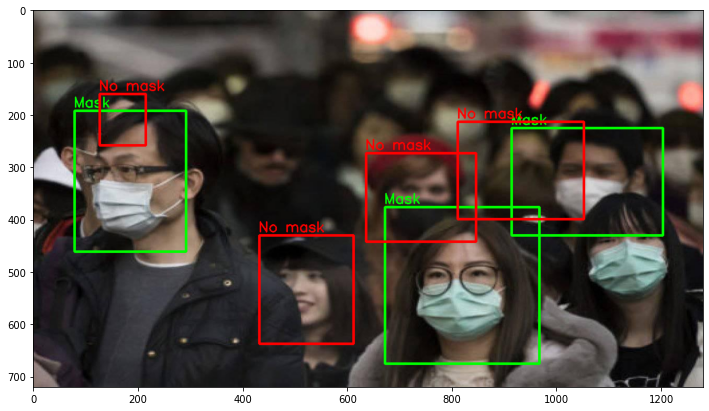

In [48]:
# Probamos sobre otra imagen
img_test = cv2.imread('multimedia/test_166.jpg') ## 102 166 134 105 (109) 116 127 122/ 160.jpeg
img_color = cv2.cvtColor(img_test, cv2.COLOR_BGR2RGB)
image_mask_detection = detect_faces_with_mask(img_color, face_detector, model_torch, ['mask', 'no_mask'], 
                                              CONFIDENCE, bbox_percentage=0.07, predictor='torch', 
                                              target_size=(IMG_WIDTH, IMG_HEIGHT))

plt.figure(figsize=(12, 12))
plt.imshow(image_mask_detection)
plt.show()

### 7. Detectamos si la persona tiene mascarillas en video

In [17]:
%%time
video = cv2.VideoCapture('multimedia/video_test_1.mp4')
W = None
H = None
writer = None

while True:
    _, frame = video.read()

    if frame is None:
        break

    if W is None or H is None:
        (H, W) = frame.shape[:2]

	# Inicializar el writer
    if writer is None:
        fourcc = cv2.VideoWriter_fourcc(*"MJPG")
        writer = cv2.VideoWriter('multimedia/output_video_01.avi', fourcc, 30, (W, H), True)

    img_color = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    img_color_temp = detect_faces_with_mask(img_color, face_detector, model_torch, ['mask', 'no_mask'], 
                                          CONFIDENCE, bbox_percentage=BBOX_PERCENTAGE, predictor='torch',
                                          target_size=(IMG_WIDTH, IMG_HEIGHT))
    if writer is not None:
        writer.write(img_color_temp[:,:,::-1])      

if writer is not None:
    writer.release()

video.release()

# Ver los resultados en la carpeta multimedia al ejecutar

CPU times: user 3.14 ms, sys: 1.92 ms, total: 5.06 ms
Wall time: 106 ms
